In [2]:
import numpy as np
import tensorflow as tf
import keras

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split


import tensorflow as tf
import keras
from keras.applications import Xception
from keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score



import matplotlib.pyplot as plt

In [3]:
#IMAGE PREPROCESSING

#converting the images to numpy arrays
def image_to_array(directory, target_size) :
        datagen = ImageDataGenerator()
        dataset_df = datagen.flow_from_directory(f'chest_xray/{directory}',
                                                classes = ['NORMAL', 'PNEUMONIA'],
                                                batch_size = 1,
                                                class_mode = 'binary',
                                                shuffle = False,
                                                target_size = (target_size, target_size)
                                                )
        
        images_df, labels_df = [], []   
        for _ in range(len(dataset_df)) :
            imgs , lbls = next(dataset_df)
            images_df.append(imgs)
            labels_df.append(lbls)
        images_df = np.squeeze(np.array(images_df)) #removing the extra dimension (batch size)
        labels_df = np.array(labels_df).flatten()   #train_test_split requires an array of shape (num_labels,) and not a 2d array  
        return images_df, labels_df


#rescaling the images => pixels rescaled between to values in range(0,1)
def rescale(x, y, shuffle_mode) :
    datagen = ImageDataGenerator(rescale=1/255)
    dataset = datagen.flow(x=x,        #for training the model shuffle the training sets so that the model doesnt learn order of images
                          y=y,         #experiment with batch size, reduce if resource gets exhausted    
                          batch_size=16,
                          shuffle=shuffle_mode)
    return dataset


#calculating class weights for dealing with imbalanced data sets
def class_weights(labels): 
    nb_pneumonia = np.count_nonzero(labels)    
    nb_normal = np.count_nonzero(labels==0)    
    
    class_weight_0 = (1/nb_normal)*((nb_pneumonia+nb_normal)/2)   #formula taken from tensorflow documentation
    class_weight_1 = (1/nb_pneumonia)*((nb_pneumonia+nb_normal)/2)
    return {0:class_weight_0, 1:class_weight_1}  


#loading images and labels 
images_df_train, labels_df_train = image_to_array('train', 150)
images_df_test, labels_df_test = image_to_array('test', 150)

#splitting the images to train and validation sets
cxr_train_img, cxr_val_img, cxr_train_label, cxr_val_label = train_test_split(images_df_train, labels_df_train, test_size=0.2, shuffle=True, random_state=42)
#Random_state=42 ensures that the shuffle is specific, random_state can be 0, 1 ..., keep experimenting for better accuracies
   
#class weights
class_weight = class_weights(cxr_train_label)

#rescaled datasets 
trainy = rescale(cxr_train_img, cxr_train_label, True) #for training the model shuffle the training sets so that the model doesnt learn order of images
valy = rescale(cxr_val_img, cxr_val_label, False)  #for validation do not shuffle since every epoch would result in a different accuracy and loss that wouldnt converge                                        
testy = rescale(images_df_test, labels_df_test, False) #for testing the model                  


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


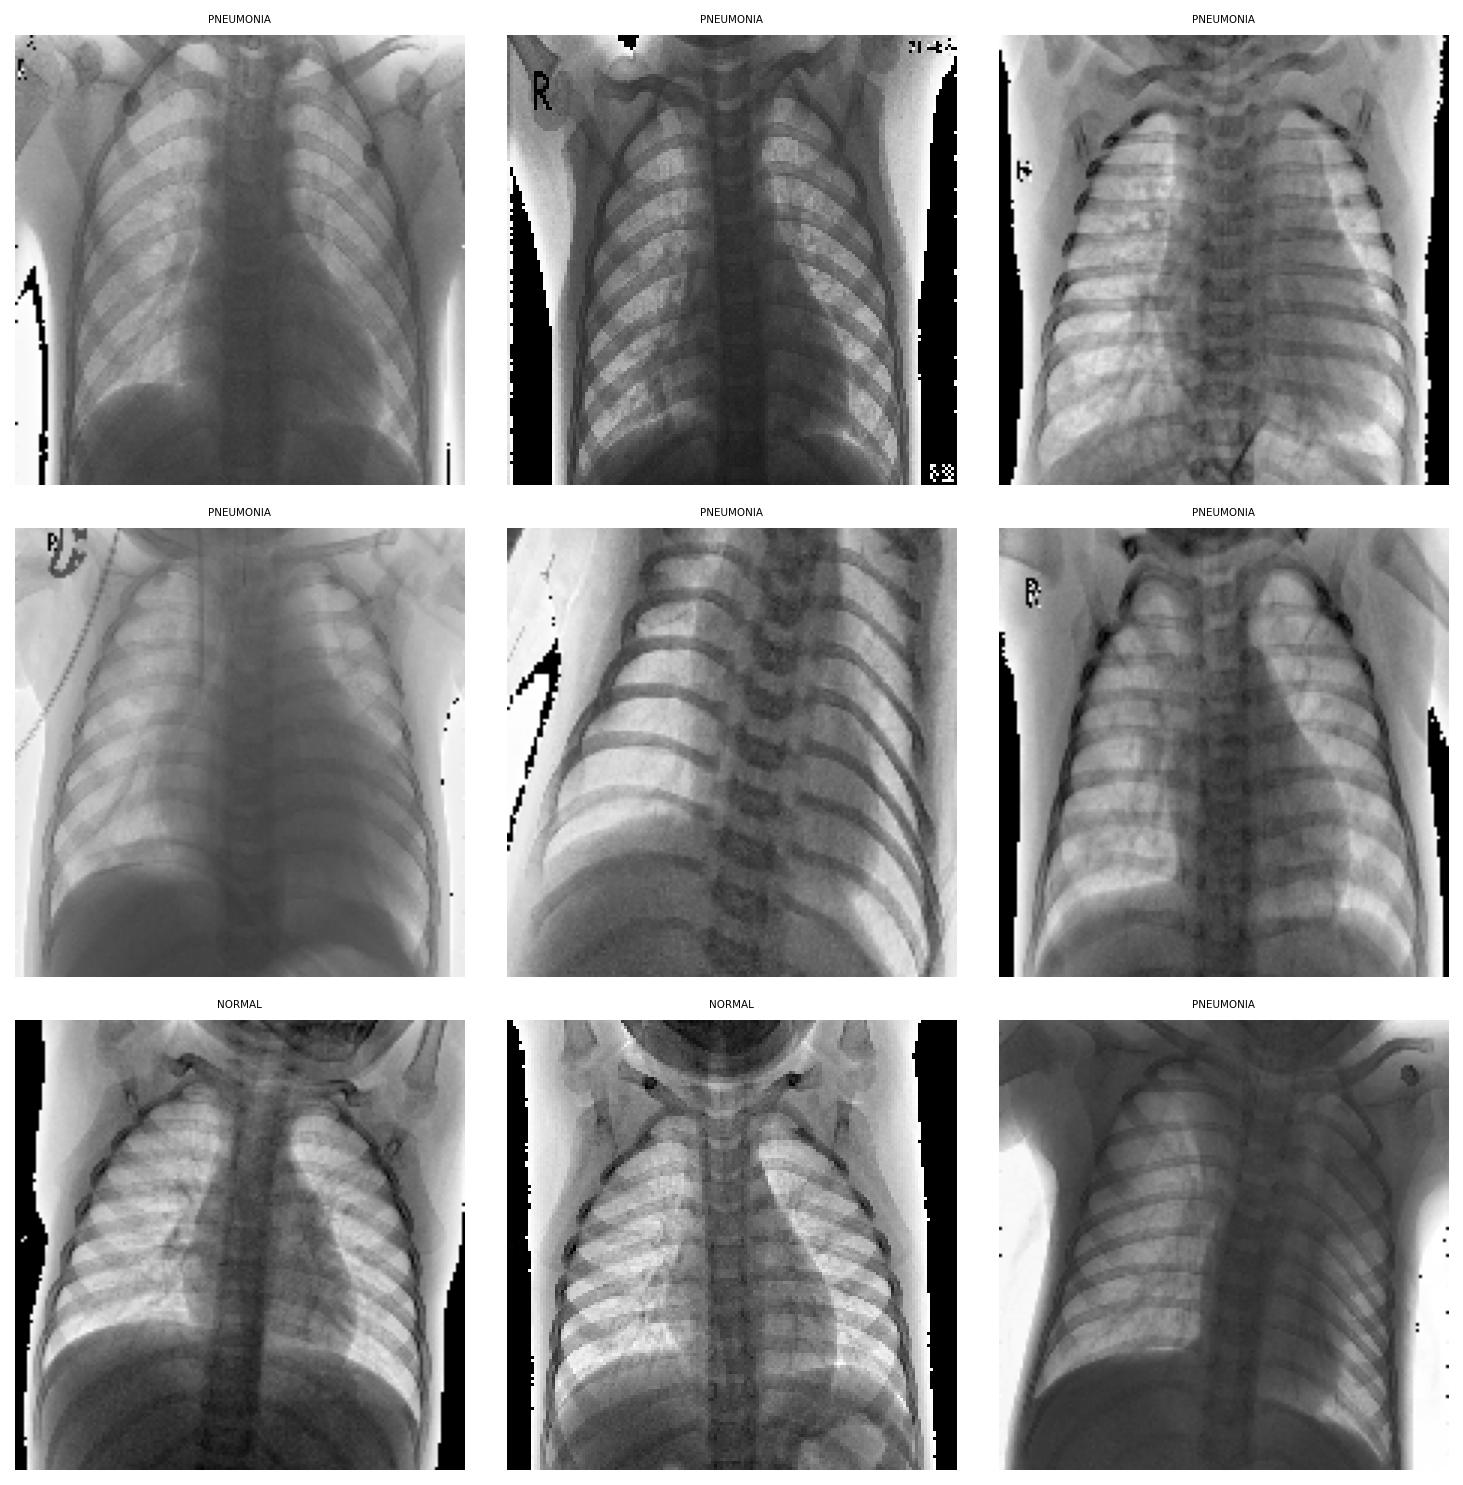

In [4]:
#VISUALIZING THE DATA
from PIL import Image
plt.figure(figsize=(10, 10), dpi = 150)

# Select random indices
indices = np.random.choice(range(len(cxr_train_label)), 9, replace=False)

for i, j in enumerate(indices):
    position = plt.subplot(3, 3, i + 1)
    # Convert numpy array to image and display
    img = Image.fromarray((cxr_train_img[j] * 255).astype(np.uint8))  
    plt.imshow(img)
    label = "NORMAL" if cxr_train_label[j] == 0 else "PNEUMONIA"
    plt.title(label, fontsize=5)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [3]:
#BUILDING THE CNN MODEL
image_size = (150,150,3)
inputs = keras.Input(shape=image_size)

xception = Xception(include_top=False, weights='imagenet', input_shape=image_size)
xception.trainable = False  #freezing the base model
x = xception(inputs, training=False) #inference mode
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(units = 1, activation= 'sigmoid')(x)  #customized classifier
ensemble_model = keras.models.Model(inputs, outputs)

ensemble_model.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 xception (Functional)       (None, 5, 5, 2048)        20861480  N          
                                                                            
 global_average_pooling2d (G  (None, 2048)             0         Y          
 lobalAveragePooling2D)                                                     
                                                                            
 dense (Dense)               (None, 1)                 2049      Y          
                                                                            
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
________________________________________________________

In [4]:
#CHECKING IF GPU IS BEING UTILIZED
print(tf.config.experimental.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
#COMPILING AND TRAINING THE MODEL
optimizer = Adam(learning_rate = 1e-4)
loss = BinaryCrossentropy()
model_checkpoint = ModelCheckpoint(filepath = 'comparison/xception_150.h5',
                                   monitor = 'val_loss',
                                   save_best_only = True,
                                   mode = 'min',
                                   verbose = 1)

ensemble_model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'] )

history = ensemble_model.fit(x = trainy, validation_data = valy, epochs = 25, callbacks=[model_checkpoint], class_weight=class_weight)


Epoch 1/25
260/261 [============================>.] - ETA: 0s - loss: 0.4471 - accuracy: 0.8133   
Epoch 1: val_loss improved from inf to 0.33236, saving model to comparison\xception_150.h5
261/261 [==============================] - 17s 43ms/step - loss: 0.4467 - accuracy: 0.8133 - val_loss: 0.3324 - val_accuracy: 0.8803
Epoch 2/25
261/261 [==============================] - ETA: 0s - loss: 0.2933 - accuracy: 0.8782 
Epoch 2: val_loss improved from 0.33236 to 0.27719, saving model to comparison\xception_150.h5
261/261 [==============================] - 10s 40ms/step - loss: 0.2933 - accuracy: 0.8782 - val_loss: 0.2772 - val_accuracy: 0.8918
Epoch 3/25
261/261 [==============================] - ETA: 0s - loss: 0.2494 - accuracy: 0.8945 
Epoch 3: val_loss improved from 0.27719 to 0.23590, saving model to comparison\xception_150.h5
261/261 [==============================] - 10s 40ms/step - loss: 0.2494 - accuracy: 0.8945 - val_loss: 0.2359 - val_accuracy: 0.9071
Epoch 4/25
261/261 [=======

In [7]:
#EVALUATING THE PERFORMANCE OF THE TRAINED MODEL
trained_model = load_model(r'comparison\xception_150.h5')
trained_model.evaluate(testy, return_dict=True)

39/39 [==============================] - 2s 31ms/step - loss: 0.4056 - accuracy: 0.8285


{'loss': 0.4056403636932373, 'accuracy': 0.8285256624221802}

In [8]:
#FINETUNING THE MODEL
optimizer = Adam(learning_rate = 1e-5)  #using a low learning rate
loss = BinaryCrossentropy()
model_checkpoint = ModelCheckpoint(filepath = 'comparison/xception_150_finetuned.h5',
                                   monitor = 'val_loss',
                                   save_best_only = True,
                                   mode = 'min',
                                   verbose = 1)
xception = trained_model.get_layer('xception')
xception.trainable = True   #unfreezing the base model layers
trained_model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'] )
history2 = trained_model.fit(x = trainy, validation_data = valy, epochs = 1, callbacks=[model_checkpoint], class_weight=class_weight)


261/261 [==============================] - ETA: 0s - loss: 0.0976 - accuracy: 0.9614   
Epoch 1: val_loss improved from inf to 0.08627, saving model to comparison\xception_150_finetuned.h5
261/261 [==============================] - 36s 117ms/step - loss: 0.0976 - accuracy: 0.9614 - val_loss: 0.0863 - val_accuracy: 0.9693


In [5]:
finetuned_model = load_model(r'comparison\xception_150_finetuned.h5')

In [6]:
#EVALUATING THE FINETUNED MODEL
finetuned_model.evaluate(testy, return_dict=True)

39/39 [==============================] - 8s 31ms/step - loss: 0.3949 - accuracy: 0.8734


{'loss': 0.39489588141441345, 'accuracy': 0.8733974099159241}

In [11]:
#ARCHITECTURE OF THE MODEL USED
finetuned_model.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 xception (Functional)       (None, 5, 5, 2048)        20861480  Y          
                                                                            
 global_average_pooling2d (G  (None, 2048)             0         Y          
 lobalAveragePooling2D)                                                     
                                                                            
 dense (Dense)               (None, 1)                 2049      Y          
                                                                            
Total params: 20,863,529
Trainable params: 20,809,001
Non-trainable params: 54,528
_______________________________________________________

In [12]:
#TESTING THE FINE TUNED MODEL ON THE TEST SET
y_pred = finetuned_model.predict(testy)
y_pred = (y_pred>0.5).astype(int)  
y_true = labels_df_test.reshape(len(labels_df_test),1) 

#PERFORMANCE METRICS : PRECISION, RECALL, F1 SCORE
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print(f'Precision : {precision}')
print(f'Recall : {recall}')
print(f"F1 Score : {f1}")
print(cm)

39/39 [==============================] - 2s 28ms/step
Precision : 0.844789356984479
Recall : 0.9769230769230769
F1 Score : 0.906064209274673
[[164  70]
 [  9 381]]


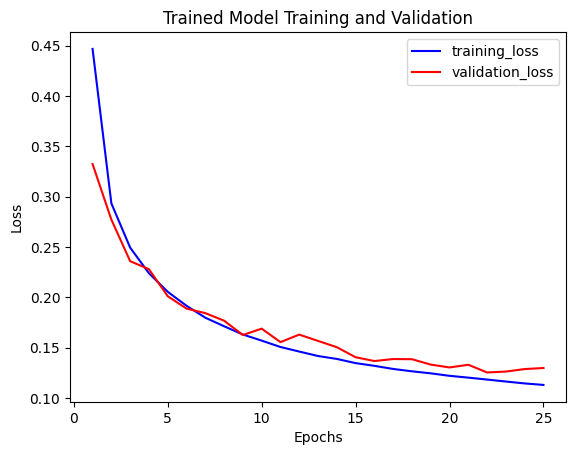

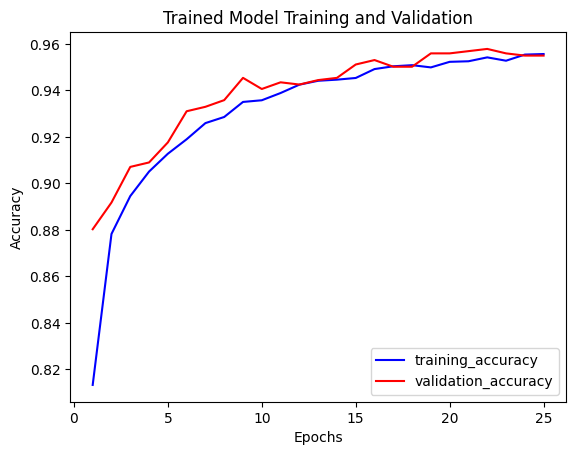

In [13]:
#PLOTTING TRAINING VS VALIDATION LOSS, ACCURACY GRAPHS
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='training_loss')
plt.plot(epochs, val_loss, 'r', label='validation_loss')
plt.title('Trained Model Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'b', label='training_accuracy')
plt.plot(epochs, val_accuracy, 'r', label='validation_accuracy')
plt.title('Trained Model Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [7]:
#TESTING THE MODEL ON A SMALLER DATASET
datagen = ImageDataGenerator(rescale=1/255)
small_testset = datagen.flow_from_directory('chest_xray/val',
                                          batch_size = 1,
                                          class_mode = 'binary',
                                          shuffle = False,
                                          target_size = (150,150))
y_pred = finetuned_model.predict(small_testset)
y_pred = (y_pred>0.5).astype('uint8')
y_pred = np.array(y_pred).flatten()
y_true = small_testset.classes


Found 16 images belonging to 2 classes.
16/16 [==============================] - 1s 10ms/step


In [8]:
#PERFORMANCE METRICS : PRECISION, RECALL, F1 SCORE
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print(f'Precision : {precision}')
print(f'Recall : {recall}')
print(f"F1 Score : {f1}")
print(cm)

Precision : 1.0
Recall : 1.0
F1 Score : 1.0
[[8 0]
 [0 8]]


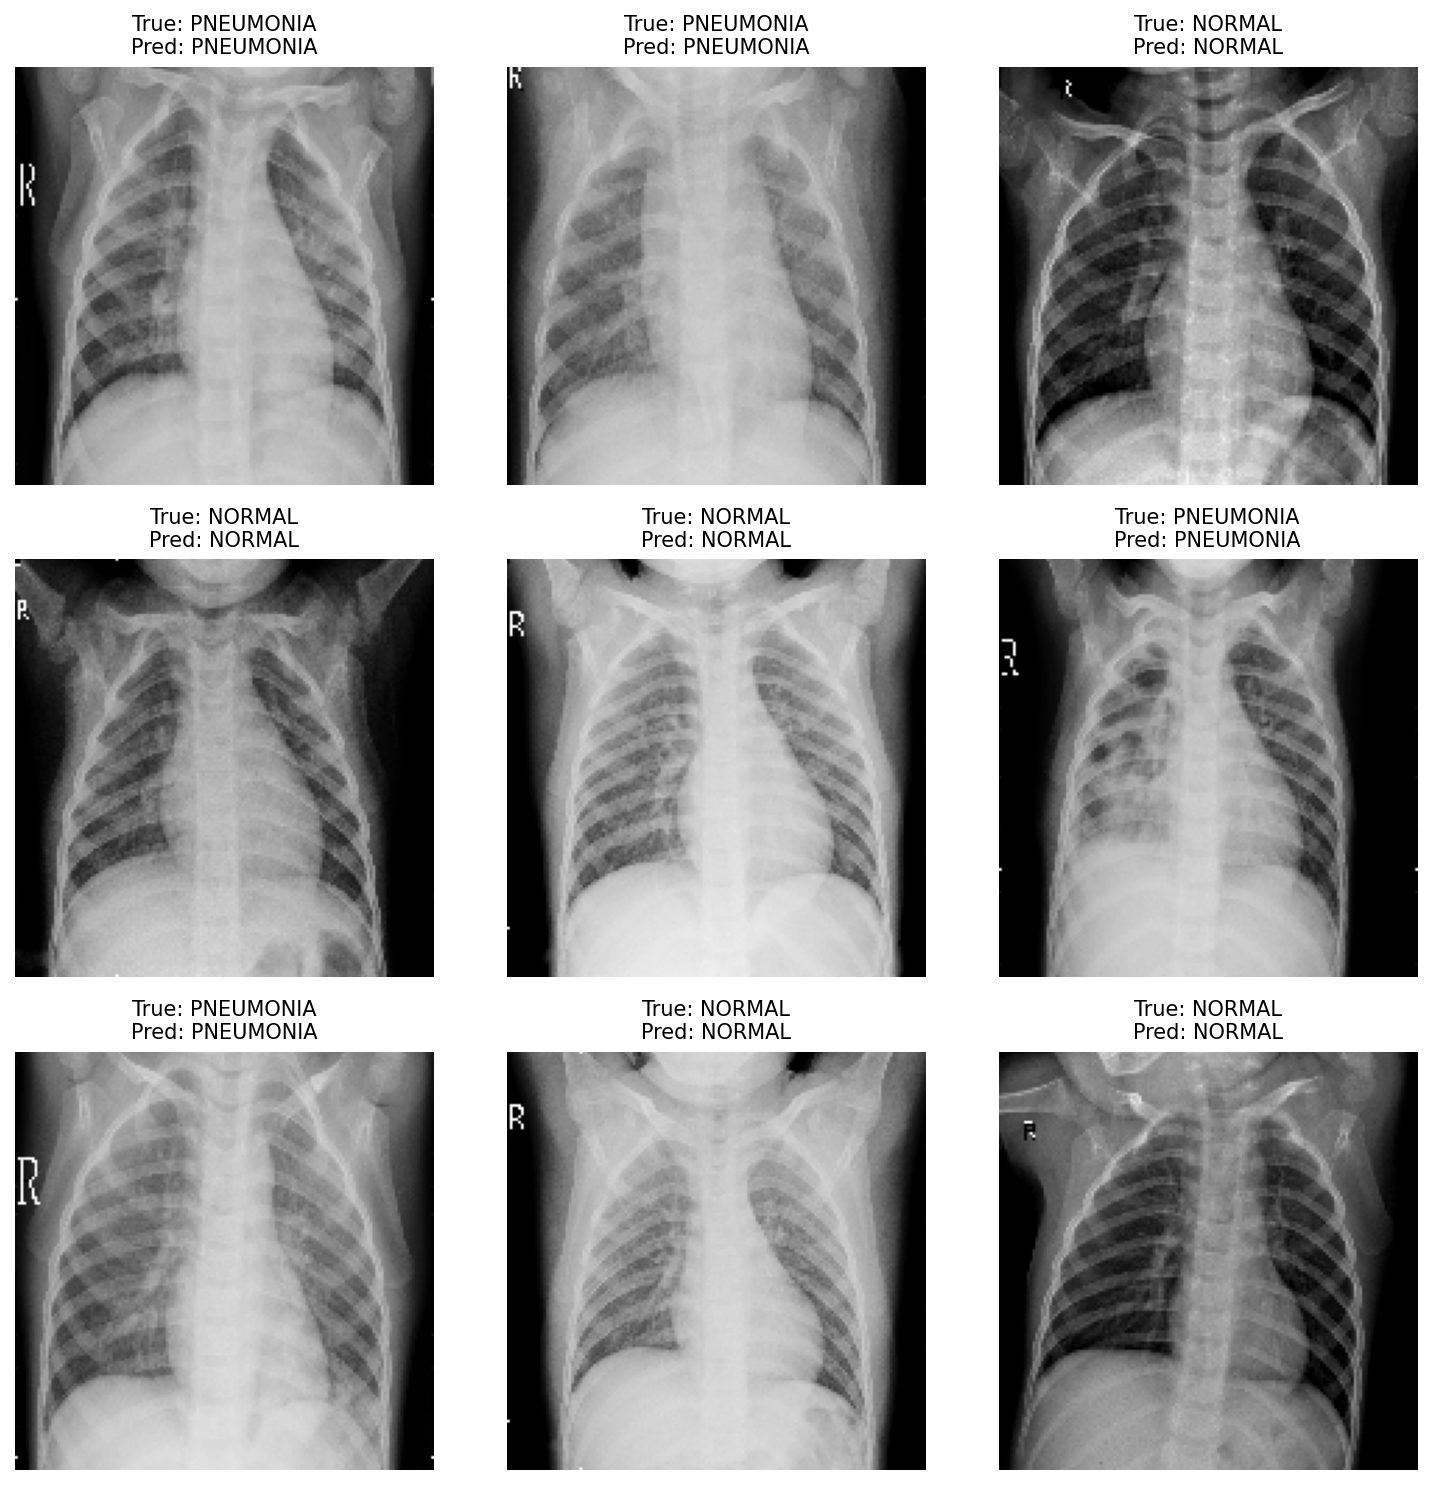

In [9]:
#VISUALIZING SOME PREDICTIONS
plt.figure(figsize=(10, 10), dpi=150)
indices = np.random.choice(range(len(y_pred)), 9, replace=False)

for i, j in enumerate(indices):
    position = plt.subplot(3, 3, i + 1)
    img = Image.fromarray((small_testset[j][0][0] * 255).astype(np.uint8)) 
    plt.imshow(img)
    # Get the true label and predicted label
    true_label = "NORMAL" if y_true[j] == 0 else "PNEUMONIA"
    pred_label = "NORMAL" if y_pred[j] == 0 else "PNEUMONIA"
    
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()